In [ ]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from tqdm import tqdm
from torch.optim import Adam
from torchvision.datasets import MNIST
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torch.utils.data import DataLoader

multipliers = [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]

def MNIST_loaders(train_batch_size=5000, test_batch_size=10000, noise_factor=0.5):
    # Function to add random noise to the images
    def add_noise(img):
        noise = torch.randn(img.size()) * noise_factor
        noisy_img = img + noise
        return torch.clamp(noisy_img, 0., 1.)  # Clamp the image to be between 0 and 1

    transform = Compose([
        ToTensor(),
        Lambda(add_noise),  # Apply the noise after converting to a tensor
        Normalize((0.1307,), (0.3081,)),
        Lambda(lambda x: torch.flatten(x))
    ])

    train_loader = DataLoader(
        MNIST('./data/', train=True, download=True, transform=transform),
        batch_size=train_batch_size, shuffle=True)

    test_loader = DataLoader(
        MNIST('./data/', train=False, download=True, transform=transform),
        batch_size=test_batch_size, shuffle=False)

    return train_loader, test_loader

def overlay_y_on_x(x, y):
    x_ = x.clone()
    x_[:, :10] *= 0.0
    x_[range(x.shape[0]), y] = x.max()
    return x_

class Layer(nn.Linear):
    def __init__(self, in_features, out_features, num_epochs=2000, bias=True, device=None, dtype=None):
        super().__init__(in_features, out_features, bias, device, dtype)
        self.relu = torch.nn.ReLU()
        self.opt = Adam(self.parameters(), lr=0.03)
        self.threshold = 2.0
        self.num_epochs = num_epochs

    def forward(self, x):
        x_direction = x / (x.norm(2, 1, keepdim=True) + 1e-4)
        return self.relu(torch.mm(x_direction, self.weight.T) + self.bias.unsqueeze(0))

    def train(self, x_pos, x_neg, test_data):
        layer_performance = []
        for i in tqdm(range(self.num_epochs)):
            g_pos = self.forward(x_pos).pow(2).mean(1)
            g_neg = self.forward(x_neg).pow(2).mean(1)
            loss = torch.log(1 + torch.exp(torch.cat([
                -g_pos + self.threshold,
                g_neg - self.threshold]))).mean()
            self.opt.zero_grad()
            loss.backward()
            self.opt.step()

            if i % 1 == 0:  # Adjust as needed
                x_te, y_te = test_data
                predictions = net.predict(x_te)
                accuracy = calculate_accuracy(predictions, y_te)
                #print(f'Epoch {i}, Accuracy: {accuracy * 100:.2f}%', 'Layer:', self)

                layer_performance.append({
                    'epoch': i,
                    'accuracy': accuracy
                })

        return self.forward(x_pos).detach(), self.forward(x_neg).detach(), layer_performance

class Net(torch.nn.Module):
    def __init__(self, dims, num_epochs_per_layer):
        super().__init__()
        self.layers = []
        for d in range(len(dims) - 1):
            num_epochs = num_epochs_per_layer[d]
            layer = Layer(dims[d], dims[d + 1], num_epochs)
            if torch.cuda.is_available():
                layer = layer.cuda()
            self.layers += [layer]

    def predict(self, x):
        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for i, layer in enumerate(self.layers):
                h = layer(h)
                layer_goodness = h.pow(2).mean(1) * multipliers[i]
                goodness += [layer_goodness]
            goodness_per_label += [sum(goodness).unsqueeze(1)]
        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.argmax(1)


    def train(self, x_pos, x_neg):
        network_performance = []
        h_pos, h_neg = x_pos, x_neg
        for i, layer in enumerate(self.layers):
            print('training layer', i, '...')
            x_te, y_te = next(iter(test_loader))
            if torch.cuda.is_available():
                x_te, y_te = x_te.cuda(), y_te.cuda()
            h_pos, h_neg, layer_performance = layer.train(h_pos, h_neg, (x_te, y_te))
            layer_info_with_performance = [{'epoch': entry['epoch'],
                                            'accuracy': entry['accuracy'],
                                            'layer': i} for entry in layer_performance]
            network_performance.extend(layer_info_with_performance)

        return network_performance

    def predict_with_scores(self, x):
        scores_per_label_and_layer = []

        for label in range(10):
            h = overlay_y_on_x(x, label)
            scores_for_label = []

            for i, layer in enumerate(self.layers):
                h = layer(h)
                layer_goodness = h.pow(2).mean(1)
                scores_for_label.append(layer_goodness)

            scores_per_label_and_layer.append(scores_for_label)

        return scores_per_label_and_layer

    def predict_with_scores2(self, x):
        x = x.view(1, -1)  # Ensure x is a 1D tensor for a single image

        goodness_per_label = []
        for label in range(10):
            h = overlay_y_on_x(x, label)
            goodness = []
            for layer in self.layers:
                h = layer(h)
                goodness += [h.pow(2).mean(1)]
            goodness_per_label += [sum(goodness).unsqueeze(1)]

        goodness_per_label = torch.cat(goodness_per_label, 1)
        return goodness_per_label.squeeze(0)  # Remove batch dimension

def calculate_accuracy(predictions, targets):
    correct = (predictions == targets).sum().item()
    total = targets.size(0)
    accuracy = correct / total
    return accuracy

In [ ]:
def plot_combined_performance(*args):
    plt.figure()

    # Predefined colors for layers
    layer_colors = ["#fd7f6f", "#7eb0d5", "#b2e061", "#bd7ebe", "#ffb55a", "#ffee65", "#beb9db", "#fdcce5", "#8bd3c7"]

    # Dictionary to store legend handles
    legend_handles = {}

    multiple_runs = len(args) > 1  # Check if there are multiple runs

    for run_index, network_performance in enumerate(args):
        max_layer = max(entry['layer'] for entry in network_performance) + 1
        epochs = [entry['epoch'] for entry in network_performance]
        accuracies = [entry['accuracy'] for entry in network_performance]
        layers = [entry['layer'] for entry in network_performance]

        for layer in set(layers):
            layer_epochs = [epochs[i] for i in range(len(epochs)) if layers[i] == layer]
            layer_accuracies = [accuracies[i] for i in range(len(accuracies)) if layers[i] == layer]

            # Plot line and store the handle
            line, = plt.plot(layer_epochs, layer_accuracies, color=layer_colors[layer], linewidth=2.5)

            # Add handle to dictionary if not already present
            if layer not in legend_handles:
                legend_handles[layer] = line

            # Annotate the last point with the run number only if there are multiple runs
            if multiple_runs and layer == max_layer - 1:
                plt.text(layer_epochs[-1], layer_accuracies[-1], f'  Network {run_index+1}',
                         verticalalignment='center', horizontalalignment='left',
                         color='grey', fontsize=9)

    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')

    plt.ylim(bottom=0, top=1)
    plt.xlim(left=0, right=max(epochs)+3)

    # Create the legend
    num_legend_entries = len(legend_handles)
    legend = plt.legend(handles=[legend_handles[layer] for layer in sorted(legend_handles)],
               labels=[f'Layer {layer}' for layer in sorted(legend_handles)],
               loc='upper center', ncol=num_legend_entries,
               bbox_to_anchor=(0.5, -0.2), frameon=False)

    for text in legend.get_texts():
        text.set_color('grey')  # Set to desired color
        text.fontsize=8

    # Customize axes and grid
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('grey')
    ax.spines['bottom'].set_color('grey')
    plt.grid(color='lightgrey', linestyle='--', linewidth=0.5)

    # Adjust layout
    plt.subplots_adjust(bottom=0.25)

    # Customize title and labels
    ax.set_xlabel('Epoch', color='grey', fontsize=10, labelpad=10)
    ax.set_ylabel('Accuracy', color='grey', fontsize=10, labelpad=10)
    ax.set_title('Accuracy Throughout Training', color='grey', fontsize=12, pad=20)
    ax.tick_params(axis='x', colors='grey', labelsize=10)
    ax.tick_params(axis='y', colors='grey', labelsize=10)

    plt.show()

100%|██████████| 9912422/9912422 [00:00<00:00, 237273139.05it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 38334080.32it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 68027614.73it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 7512038.16it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw

training layer 0 ...


100%|██████████| 500/500 [01:01<00:00,  8.15it/s]


training layer 1 ...


100%|██████████| 500/500 [01:00<00:00,  8.30it/s]


training layer 2 ...


100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


training layer 3 ...


100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


training layer 4 ...


100%|██████████| 500/500 [01:00<00:00,  8.25it/s]


Network Performance for Configuration 1: [{'epoch': 0, 'accuracy': 0.0892, 'layer': 0}, {'epoch': 1, 'accuracy': 0.0892, 'layer': 0}, {'epoch': 2, 'accuracy': 0.0892, 'layer': 0}, {'epoch': 3, 'accuracy': 0.0892, 'layer': 0}, {'epoch': 4, 'accuracy': 0.0892, 'layer': 0}, {'epoch': 5, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 6, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 7, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 8, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 9, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 10, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 11, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 12, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 13, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 14, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 15, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 16, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 17, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 18, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 19, 'accuracy': 0.1135, 'layer': 0}, {'epoch': 20, 'accuracy': 0.

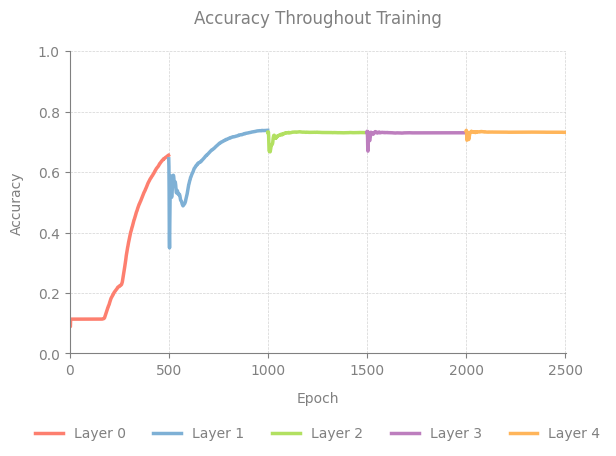

In [ ]:
import torch

if __name__ == "__main__":
    torch.manual_seed(1234)
    train_loader, test_loader = MNIST_loaders()

    # Define two network configurations
    network_configs = [
        ([784,500,500,500,500,500], [500,500,500,500,500])
    ]

    all_network_performances = []

    for config_index, (dims, num_epochs_per_layer) in enumerate(network_configs):
        net = Net(dims, num_epochs_per_layer)
        if torch.cuda.is_available():
            net = net.cuda()

        x, y = next(iter(train_loader))
        if torch.cuda.is_available():
            x, y = x.cuda(), y.cuda()

        x_pos = overlay_y_on_x(x, y)
        rnd = torch.randperm(x.size(0))
        x_neg = overlay_y_on_x(x, y[rnd])

        network_performance = net.train(x_pos, x_neg)
        print(f'Network Performance for Configuration {config_index + 1}:', network_performance)

        train_predictions = net.predict(x)
        train_accuracy = calculate_accuracy(train_predictions, y)
        print('Train Accuracy:', train_accuracy * 100, '%')
        print('Train Error:', 100 - train_accuracy * 100, '%')

        x_te, y_te = next(iter(test_loader))
        if torch.cuda.is_available():
            x_te, y_te = x_te.cuda(), y_te.cuda()

        test_predictions = net.predict(x_te)
        test_accuracy = calculate_accuracy(test_predictions, y_te)
        print('Test Accuracy:', test_accuracy * 100, '%')
        print('Test Error:', 100 - test_accuracy * 100, '%')

        # Update the epoch counter for each entry
        epoch_counter = 0
        for entry in network_performance:
            entry['epoch'] = epoch_counter
            epoch_counter += 1

        all_network_performances.append(network_performance)

    # Plotting combined performance
    plot_combined_performance(*all_network_performances)

In [ ]:
# Print the label of the first image in the batch
print("Label of x_te[0]:", y_te[0].item())

# Load the first image from the test set
x_te, y_te = next(iter(test_loader))
single_image = x_te[0]
true_label = y_te[0].item()
print("Label of x_te[0]:", true_label)

# Add batch dimension and transfer to GPU if available
single_image_batch = single_image.unsqueeze(0)
if torch.cuda.is_available():
    single_image_batch = single_image_batch.cuda()

# Get the goodness scores for each digit and each layer
goodness_scores = net.predict_with_scores(single_image_batch)

# Convert scores to a list for easier printing
goodness_scores_list = [[layer_score.item() for layer_score in label_scores] for label_scores in goodness_scores]

# Print goodness scores for each digit, broken down by layer
print("Goodness scores for each digit, broken down by layer:")
for digit, scores in enumerate(goodness_scores_list):
    print(f"Digit {digit}: {scores}")


Label of x_te[0]: 7
Label of x_te[0]: 7
Goodness scores for each digit, broken down by layer:
Digit 0: [0.685723066329956, 0.0, 1.6036156011978164e-05, 0.0, 0.0]
Digit 1: [1.9222921133041382, 1.2903697490692139, 2.087582588195801, 2.533846855163574, 2.5101890563964844]
Digit 2: [0.7043517827987671, 0.028528928756713867, 0.3453008830547333, 0.21106086671352386, 0.2605646550655365]
Digit 3: [1.2932260036468506, 0.9226083159446716, 1.238410472869873, 2.2693428993225098, 2.240140676498413]
Digit 4: [1.5176985263824463, 0.7554823160171509, 1.3090277910232544, 2.0643270015716553, 2.5223755836486816]
Digit 5: [1.199298620223999, 0.6842928528785706, 1.7625995874404907, 2.177361488342285, 2.2500505447387695]
Digit 6: [0.6115190982818604, 0.0, 1.6036156011978164e-05, 0.0, 0.0]
Digit 7: [2.373061418533325, 3.9480948448181152, 3.481558322906494, 2.8632593154907227, 2.560227394104004]
Digit 8: [1.314209222793579, 0.05496218800544739, 0.008862937800586224, 0.0, 0.0]
Digit 9: [2.1781632900238037, 2.6

In [ ]:
    # Print the label of the first image in the batch
    print("Label of x_te[0]:", y_te[0].item())

    # Testing the predict_with_scores2 method
    x_te, y_te = next(iter(test_loader))
    single_image = x_te[0]
    if torch.cuda.is_available():
        single_image = single_image.cuda()

    goodness_scores = net.predict_with_scores2(single_image)
    print("Goodness scores for each digit:", goodness_scores.tolist())

Label of x_te[0]: 7
Goodness scores for each digit: [1.5240504741668701, 14.630661010742188, 1.4023652076721191, 9.385232925415039, 8.288949012756348, 1.7346160411834717, 1.437323808670044, 17.223196029663086, 9.320152282714844, 13.90737533569336]


In [ ]:
import torch
import numpy as np

# Assuming net is your trained model and train_loader is your training data loader

# Initialize storage for cumulative goodness scores and label counts
num_layers = len(net.layers)
goodness_sums = np.zeros((10, 10, num_layers))  # 10 digits, 10 possible labels, N layers
label_counts = np.zeros(10)

for images, labels in train_loader:
    for image, label in zip(images, labels):
        label_counts[label] += 1

        # Add batch dimension and transfer to GPU if available
        image_batch = image.unsqueeze(0)
        if torch.cuda.is_available():
            image_batch = image_batch.cuda()

        # Get goodness scores for each digit and each layer
        goodness_scores = net.predict_with_scores(image_batch)
        goodness_scores_list = [[layer_score.item() for layer_score in label_scores] for label_scores in goodness_scores]

        # Update cumulative scores
        for digit in range(10):
            for layer in range(num_layers):
                goodness_sums[label, digit, layer] += goodness_scores_list[digit][layer]

# Calculate the average goodness for each actual label for each layer
average_goodness = goodness_sums / label_counts[:, None, None]

# Print the average goodness scores for each digit, broken down by layer
for layer in range(num_layers):
    print(f"Layer {layer}:")
    for digit in range(10):
        print(f"Digit {digit}: {average_goodness[:, digit, layer]}")


Layer 0:
Digit 0: [2.66666371 0.84393903 1.655615   1.79697758 1.08178439 1.92073711
 1.66815781 0.96864535 1.41917883 0.94318853]
Digit 1: [0.71386865 2.96031782 1.64653605 1.60252612 1.71949145 1.25537911
 1.27414623 2.46000798 1.84683061 1.98098224]
Digit 2: [1.9551466  1.67307636 2.4243515  1.86463299 1.35116629 1.68531041
 2.26089824 1.00712512 1.71023678 1.02428163]
Digit 3: [2.03511055 1.65326128 1.84444212 2.4475236  1.1121812  2.10312422
 1.47149583 1.31957268 1.90555402 1.17981147]
Digit 4: [1.25569905 1.53868154 1.45478862 1.09205474 2.66514594 1.3691623
 1.91812875 2.27219009 1.20726895 2.3611179 ]
Digit 5: [2.53491446 1.33586904 1.84562106 2.32761863 1.53413106 2.41140933
 1.87675593 1.35035234 1.87133019 1.42102421]
Digit 6: [1.9515899  1.3390738  2.19425925 1.45909296 1.80430936 1.61364507
 2.60718378 1.06159341 1.42416227 1.28700861]
Digit 7: [0.78392399 2.04583604 1.00927264 1.21239927 2.05559243 1.12654555
 0.92413387 2.86822175 1.39764395 2.3773709 ]
Digit 8: [1.8085

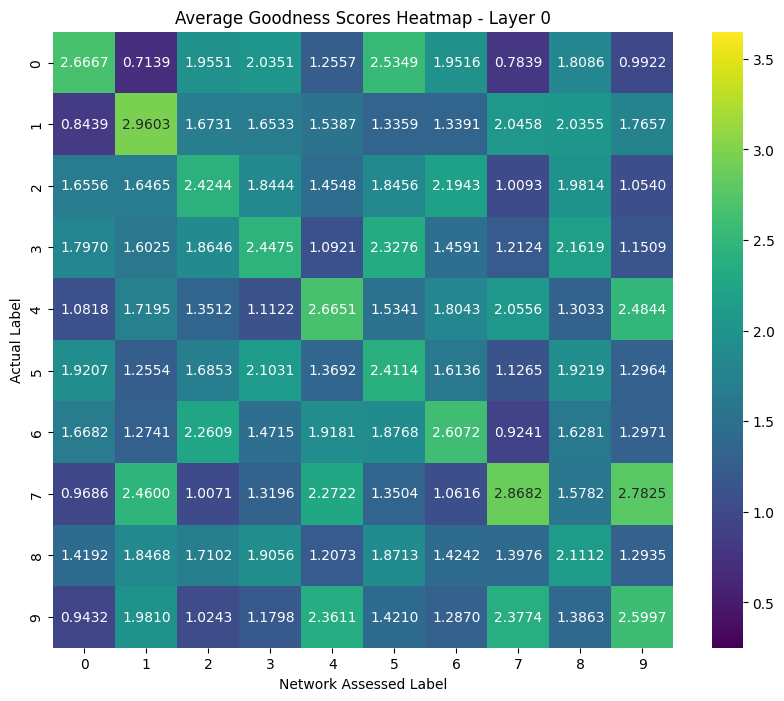

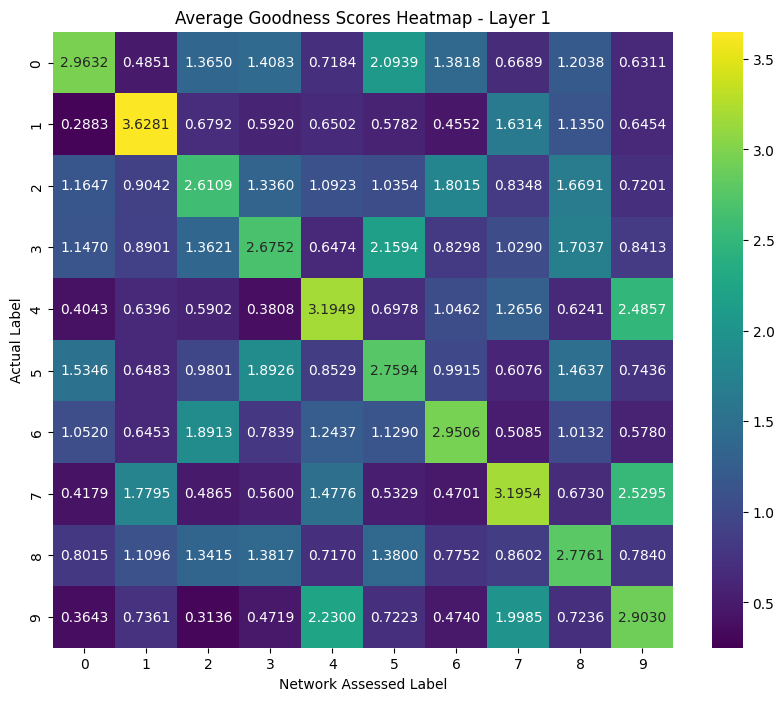

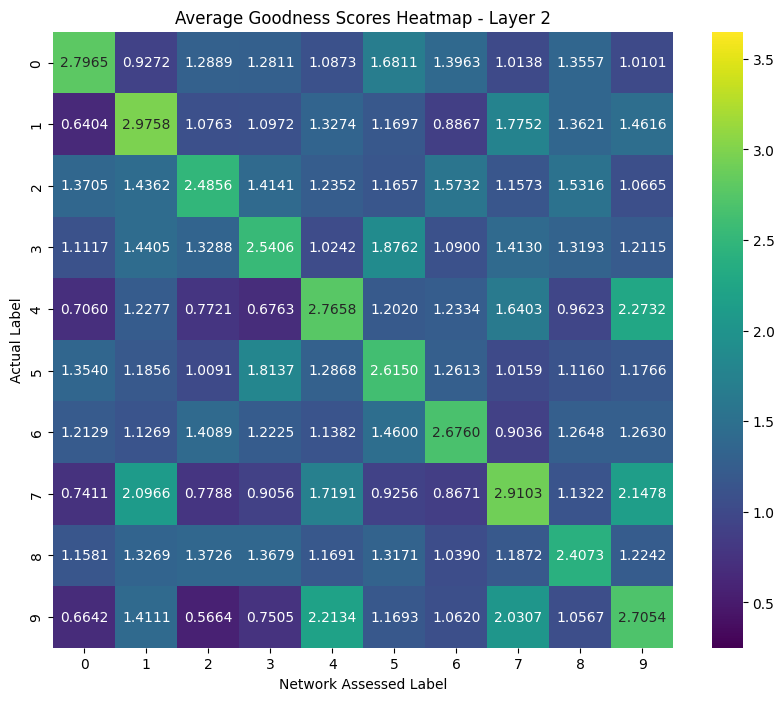

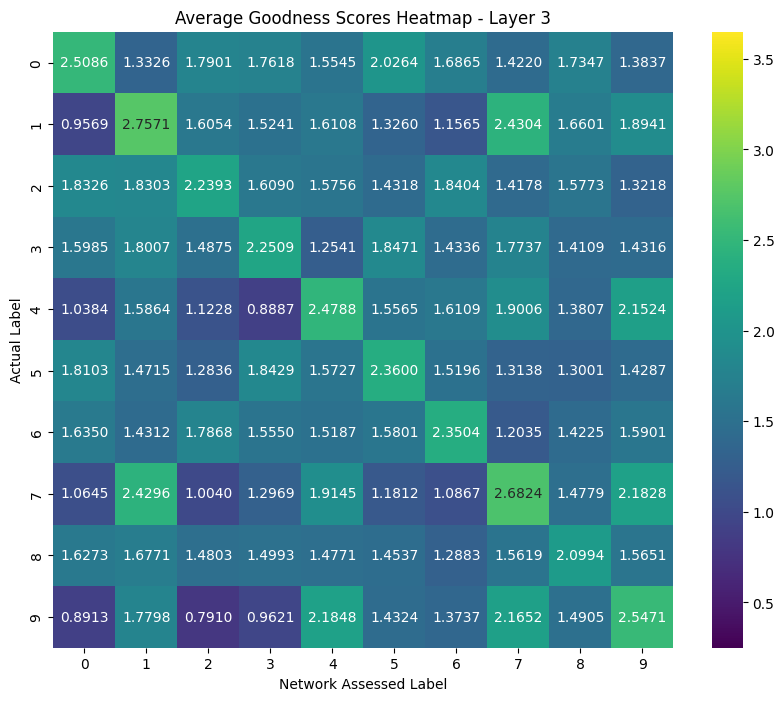

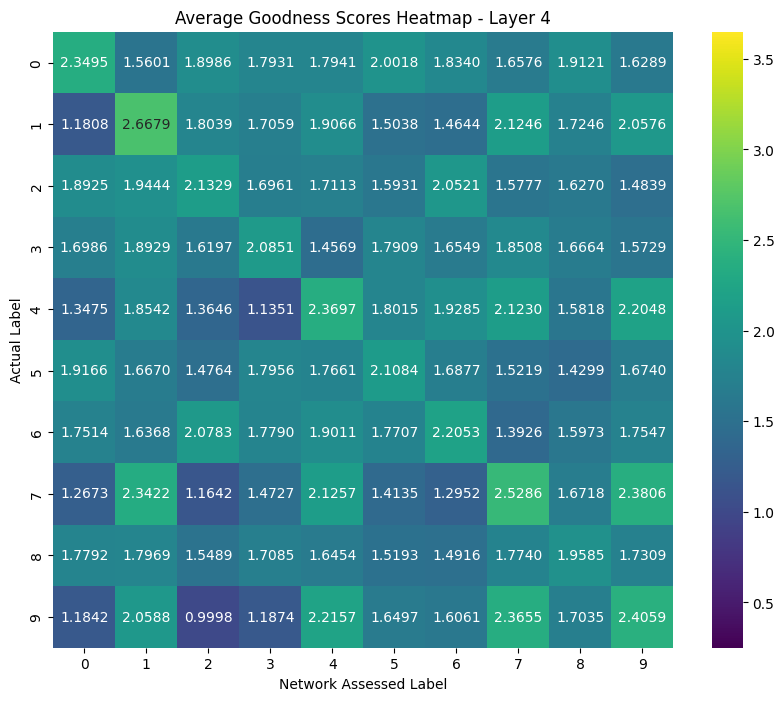

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming average_goodness is your 10x10xN numpy array
num_layers = average_goodness.shape[2]

for layer in range(num_layers):
    plt.figure(figsize=(10, 8))
    sns.heatmap(average_goodness[:, :, layer], annot=True, fmt=".4f", cmap='viridis',
                xticklabels=[str(i) for i in range(10)],
                yticklabels=[str(i) for i in range(10)],vmin=0.25, vmax=3.65)
    plt.title(f'Average Goodness Scores Heatmap - Layer {layer}')
    plt.xlabel('Network Assessed Label')
    plt.ylabel('Actual Label')
    plt.show()